In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import bbknn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import pymn
import itertools
import harmonypy

2022-10-15 00:53:40.397351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 00:53:40.501960: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-15 00:53:40.506518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-15 00:53:40.506530: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:

maize_single_cell = sc.read_h5ad('/data/passala/Collaborator_Data/Maize_arabi_Jack_Collab/xu16_19_29_32_SeuratV4.0.1_finalclustermaize.h5ad')
maize_single_cell #Test annotation for my data

AnnData object with n_obs × n_vars = 10551 × 28492
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'DataSet', 'integrated_snn_res.1', 'seurat_clusters', 'test_res.1', 'determinate', 'subcluster9', 'mygraph_res.1'
    var: '_index', 'features'
    obsm: 'X_umap'

In [3]:
arabi_single_cell = sc.read_h5ad('/data/passala/Collaborator_Data/Maize_arabi_Jack_Collab/xu_41_42.int_filter_recluster_final_forBen_arabi.h5ad')
arabi_single_cell

AnnData object with n_obs × n_vars = 20224 × 23339
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'source', 'integrated_snn_res.0.5', 'integrated_snn_res.0.75', 'integrated_snn_res.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'integrated_snn_res.0.45', 'integrated_snn_res.0.25', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.65', 'integrated_snn_res.0.6', 'integrated_snn_res.0.55', 'integrated_snn_res.0.53', 'integrated_snn_res.0.52', 'integrated_snn_res.0.54'
    var: '_index', 'features'
    obsm: 'X_umap'

In [4]:
co_expressalog_map_85 = pd.read_csv('/home/passala/Gene_duplication_project/Code/Jack_Dave_maize_project/Minor_tables/true_pair_dataframe_at_80_tolerance.csv')
ensmbl_to_grm = pd.read_csv('/home/passala/Gene_duplication_project/Code/Jack_Dave_maize_project/Minor_tables/ensmbl_to_grm_table.csv')
co_expressalog_map_85

,Arabidopsis Gene,Maize Gene
0,AT3G50620,Zm00001d029417
1,AT2G15730,Zm00001d052886
2,AT5G44040,Zm00001d027589
3,AT5G42760,Zm00001d034249
4,AT3G53470,Zm00001d031954
...,...,...
6230,AT2G35170,Zm00001d000053
6231,AT4G17540,Zm00001d000035
6232,AT4G16970,Zm00001d000034
6233,AT2G15980,Zm00001d000435


In [5]:
co_expressalog_map_85 = co_expressalog_map_85.merge(right = ensmbl_to_grm, how = 'left', left_on= 'Maize Gene', right_on= 'EnsemblID')
co_expressalog_map_85 = co_expressalog_map_85.dropna()
co_expressalog_map_85 = co_expressalog_map_85[['Arabidopsis Gene','GRM Name']]


In [6]:
co_expressalog_map_85

,Arabidopsis Gene,GRM Name
0,AT3G50620,GRMZM2G003530
1,AT2G15730,GRMZM5G877077
2,AT5G44040,GRMZM2G172758
3,AT5G42760,GRMZM2G068179
4,AT3G53470,GRMZM2G144982
...,...,...
6225,AT4G18370,GRMZM2G118646
6227,AT1G77840,EIF5
6228,AT1G71696,GRMZM2G106683
6229,AT4G27030,GRMZM2G175401


In [7]:
arabi_single_cell.var.index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '23329', '23330', '23331', '23332', '23333', '23334', '23335', '23336',
       '23337', '23338'],
      dtype='object', length=23339)

In [8]:
arabi_single_cell.var = arabi_single_cell.var.merge(right = co_expressalog_map_85, right_on = 'Arabidopsis Gene', how = 'left', left_on = 'features')

arabi_single_cell.var.index = arabi_single_cell.var['features'].to_list()
arabi_single_cell.var

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


,_index,features,Arabidopsis Gene,GRM Name
AT1G01010,AT1G01010,AT1G01010,NaN,NaN
AT1G01020,AT1G01020,AT1G01020,NaN,NaN
AT1G01030,AT1G01030,AT1G01030,NaN,NaN
AT1G01040,AT1G01040,AT1G01040,NaN,NaN
AT1G01050,AT1G01050,AT1G01050,AT1G01050,GRMZM2G061928
...,...,...,...,...
AT5G67060,AT5G67060,AT5G67060,NaN,NaN
ATCG00830,ATCG00830,ATCG00830,NaN,NaN
ATCG00920,ATCG00920,ATCG00920,NaN,NaN
ATCG01000,ATCG01000,ATCG01000,NaN,NaN


In [9]:
maize_single_cell.var

,_index,features
0,GRMZM2G059865,GRMZM2G059865
1,GRMZM2G093344,GRMZM2G093344
2,GRMZM2G306216,GRMZM2G306216
3,GRMZM2G104572,GRMZM2G104572
4,GRMZM5G822187,GRMZM5G822187
...,...,...
28487,GRMZM2G128549,GRMZM2G128549
28488,GRMZM2G450231,GRMZM2G450231
28489,GRMZM2G074773,GRMZM2G074773
28490,GRMZM5G826672,GRMZM5G826672


In [10]:
co_expressalog_map_85

,Arabidopsis Gene,GRM Name
0,AT3G50620,GRMZM2G003530
1,AT2G15730,GRMZM5G877077
2,AT5G44040,GRMZM2G172758
3,AT5G42760,GRMZM2G068179
4,AT3G53470,GRMZM2G144982
...,...,...
6225,AT4G18370,GRMZM2G118646
6227,AT1G77840,EIF5
6228,AT1G71696,GRMZM2G106683
6229,AT4G27030,GRMZM2G175401


In [11]:
maize_single_cell.var

,_index,features
0,GRMZM2G059865,GRMZM2G059865
1,GRMZM2G093344,GRMZM2G093344
2,GRMZM2G306216,GRMZM2G306216
3,GRMZM2G104572,GRMZM2G104572
4,GRMZM5G822187,GRMZM5G822187
...,...,...
28487,GRMZM2G128549,GRMZM2G128549
28488,GRMZM2G450231,GRMZM2G450231
28489,GRMZM2G074773,GRMZM2G074773
28490,GRMZM5G826672,GRMZM5G826672


In [12]:
maize_single_cell.var.merge(right = co_expressalog_map_85, right_on = 'GRM Name', how = 'left', left_on = 'features')


,_index,features,Arabidopsis Gene,GRM Name
0,GRMZM2G059865,GRMZM2G059865,NaN,NaN
1,GRMZM2G093344,GRMZM2G093344,NaN,NaN
2,GRMZM2G306216,GRMZM2G306216,NaN,NaN
3,GRMZM2G104572,GRMZM2G104572,NaN,NaN
4,GRMZM5G822187,GRMZM5G822187,NaN,NaN
...,...,...,...,...
28487,GRMZM2G128549,GRMZM2G128549,NaN,NaN
28488,GRMZM2G450231,GRMZM2G450231,NaN,NaN
28489,GRMZM2G074773,GRMZM2G074773,NaN,NaN
28490,GRMZM5G826672,GRMZM5G826672,NaN,NaN


In [13]:
maize_single_cell.var = maize_single_cell.var.merge(right = co_expressalog_map_85, right_on = 'GRM Name', how = 'left', left_on = 'features')

maize_single_cell.var.index = maize_single_cell.var['features'].to_list()
maize_single_cell.var

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


,_index,features,Arabidopsis Gene,GRM Name
GRMZM2G059865,GRMZM2G059865,GRMZM2G059865,NaN,NaN
GRMZM2G093344,GRMZM2G093344,GRMZM2G093344,NaN,NaN
GRMZM2G306216,GRMZM2G306216,GRMZM2G306216,NaN,NaN
GRMZM2G104572,GRMZM2G104572,GRMZM2G104572,NaN,NaN
GRMZM5G822187,GRMZM5G822187,GRMZM5G822187,NaN,NaN
...,...,...,...,...
GRMZM2G128549,GRMZM2G128549,GRMZM2G128549,NaN,NaN
GRMZM2G450231,GRMZM2G450231,GRMZM2G450231,NaN,NaN
GRMZM2G074773,GRMZM2G074773,GRMZM2G074773,NaN,NaN
GRMZM5G826672,GRMZM5G826672,GRMZM5G826672,NaN,NaN


In [14]:
arabi_var_names_with_ortholog = arabi_single_cell.var.dropna().index
arabi_version_of_maize_genes_with_ortholog = maize_single_cell.var.dropna()['Arabidopsis Gene'].to_list()

In [15]:
overlap_of_shared_genes = arabi_var_names_with_ortholog.intersection(arabi_version_of_maize_genes_with_ortholog)
overlap_of_shared_genes

Index(['AT1G01090', 'AT1G01140', 'AT1G01210', 'AT1G01225', 'AT1G01350',
       'AT1G01360', 'AT1G01370', 'AT1G01470', 'AT1G01490', 'AT1G01500',
       ...
       'AT5G67440', 'AT5G67500', 'AT5G67530', 'AT5G67540', 'AT5G67590',
       'AT1G44608', 'AT2G18360', 'AT2G20825', 'AT2G30424', 'AT4G19645'],
      dtype='object', length=4903)

In [16]:
maize_genes_to_keep = maize_single_cell.var.loc[maize_single_cell.var['Arabidopsis Gene'].isin(overlap_of_shared_genes)].index

In [17]:
maize_single_cell_trimmed_to_orthologs = maize_single_cell[:,maize_genes_to_keep]
maize_single_cell_trimmed_to_orthologs

View of AnnData object with n_obs × n_vars = 10551 × 4903
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'DataSet', 'integrated_snn_res.1', 'seurat_clusters', 'test_res.1', 'determinate', 'subcluster9', 'mygraph_res.1'
    var: '_index', 'features', 'Arabidopsis Gene', 'GRM Name'
    obsm: 'X_umap'

In [18]:
arabi_single_cell_slimmed_to_orthologs = arabi_single_cell[:,overlap_of_shared_genes]
arabi_single_cell_slimmed_to_orthologs

View of AnnData object with n_obs × n_vars = 20224 × 4903
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'source', 'integrated_snn_res.0.5', 'integrated_snn_res.0.75', 'integrated_snn_res.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'integrated_snn_res.0.45', 'integrated_snn_res.0.25', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.65', 'integrated_snn_res.0.6', 'integrated_snn_res.0.55', 'integrated_snn_res.0.53', 'integrated_snn_res.0.52', 'integrated_snn_res.0.54'
    var: '_index', 'features', 'Arabidopsis Gene', 'GRM Name'
    obsm: 'X_umap'

In [19]:
maize_single_cell_trimmed_to_orthologs.var.index = maize_single_cell_trimmed_to_orthologs.var['Arabidopsis Gene'].to_list()
maize_single_cell_trimmed_to_orthologs.var

,_index,features,Arabidopsis Gene,GRM Name
AT3G60340,GRMZM2G374779,GRMZM2G374779,AT3G60340,GRMZM2G374779
AT5G61520,GRMZM2G374812,GRMZM2G374812,AT5G61520,GRMZM2G374812
AT5G61510,GRMZM2G002121,GRMZM2G002121,AT5G61510,GRMZM2G002121
AT4G30600,GRMZM2G060296,GRMZM2G060296,AT4G30600,GRMZM2G060296
AT4G11450,GRMZM2G703466,GRMZM2G703466,AT4G11450,GRMZM2G703466
...,...,...,...,...
AT1G65032,GRMZM2G431885,GRMZM2G431885,AT1G65032,GRMZM2G431885
AT3G50400,GRMZM2G070178,GRMZM2G070178,AT3G50400,GRMZM2G070178
AT5G49810,GRMZM2G098031,GRMZM2G098031,AT5G49810,GRMZM2G098031
AT2G18660,GRMZM2G099092,GRMZM2G099092,AT2G18660,GRMZM2G099092


In [20]:
order_of_vars = arabi_single_cell_slimmed_to_orthologs.var.index.to_list()
current_order_maize_vars = maize_single_cell_trimmed_to_orthologs.var_names
panda_version_of_maize_x_data = pd.DataFrame(columns = current_order_maize_vars, data = maize_single_cell_trimmed_to_orthologs.X.todense())

re_ordered_version = panda_version_of_maize_x_data.reindex(columns = order_of_vars)
re_ordered_version = sparse.csr_matrix(re_ordered_version.values)
maize_single_cell_trimmed_to_orthologs.X = re_ordered_version
maize_single_cell_trimmed_to_orthologs.var = maize_single_cell_trimmed_to_orthologs.var.reindex(order_of_vars)

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:882: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "var")


In [21]:
# maize_single_cell_trimmed_to_orthologs.obs['Species'] = 'Maize'
# arabi_single_cell_slimmed_to_orthologs.obs['Species'] = 'Arabidopsis'


In [22]:
concatendated_arabi_maize_dataset = arabi_single_cell_slimmed_to_orthologs.concatenate(maize_single_cell_trimmed_to_orthologs, batch_key = 'Species', batch_categories = ['Arabidopsis','Maize'])

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [23]:
sc.pp.highly_variable_genes(concatendated_arabi_maize_dataset, min_mean=0.01, max_mean=4, min_disp=0.1)


In [24]:
concatendated_arabi_maize_dataset

AnnData object with n_obs × n_vars = 30775 × 4903
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'source', 'integrated_snn_res.0.5', 'integrated_snn_res.0.75', 'integrated_snn_res.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'integrated_snn_res.0.45', 'integrated_snn_res.0.25', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.65', 'integrated_snn_res.0.6', 'integrated_snn_res.0.55', 'integrated_snn_res.0.53', 'integrated_snn_res.0.52', 'integrated_snn_res.0.54', 'DataSet', 'test_res.1', 'determinate', 'subcluster9', 'mygraph_res.1', 'Species'
    var: 'Arabidopsis Gene', 'GRM Name', '_index-Arabidopsis', 'features-Arabidopsis', '_index-Maize', 'features-Maize', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_umap'

In [25]:
concatendated_arabi_maize_dataset.var.sum()

Arabidopsis Gene        AT1G01090AT1G01140AT1G01210AT1G01225AT1G01350A...
GRM Name                GRMZM2G033894GRMZM2G055575GRMZM2G138407GRMZM2G...
_index-Arabidopsis      AT1G01090AT1G01140AT1G01210AT1G01225AT1G01350A...
features-Arabidopsis    AT1G01090AT1G01140AT1G01210AT1G01225AT1G01350A...
_index-Maize            GRMZM2G033894GRMZM2G055575GRMZM2G138407GRMZM2G...
features-Maize          GRMZM2G033894GRMZM2G055575GRMZM2G138407GRMZM2G...
highly_variable                                                      1765
means                                                          1272.23048
dispersions                                                   3809.926824
dispersions_norm                                                 1.999996
dtype: object

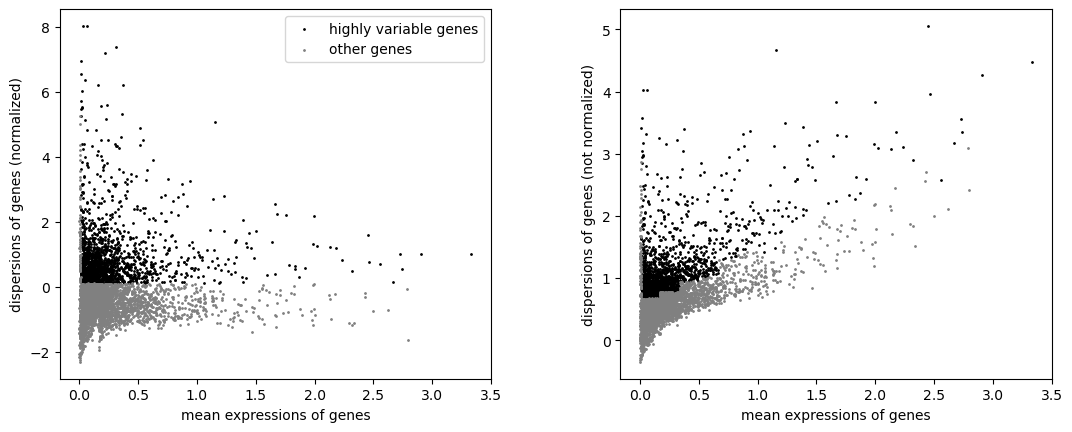

In [26]:
sc.pl.highly_variable_genes(concatendated_arabi_maize_dataset)


In [27]:
sc.pp.pca(concatendated_arabi_maize_dataset)
sc.external.pp.harmony_integrate(concatendated_arabi_maize_dataset,'Species')

2022-02-04 14:43:09,130 - harmonypy - INFO - Iteration 1 of 10
2022-02-04 14:43:15,896 - harmonypy - INFO - Iteration 2 of 10
2022-02-04 14:43:22,774 - harmonypy - INFO - Converged after 2 iterations


In [28]:
concatendated_arabi_maize_dataset

AnnData object with n_obs × n_vars = 30775 × 4903
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'source', 'integrated_snn_res.0.5', 'integrated_snn_res.0.75', 'integrated_snn_res.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'integrated_snn_res.0.45', 'integrated_snn_res.0.25', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.65', 'integrated_snn_res.0.6', 'integrated_snn_res.0.55', 'integrated_snn_res.0.53', 'integrated_snn_res.0.52', 'integrated_snn_res.0.54', 'DataSet', 'test_res.1', 'determinate', 'subcluster9', 'mygraph_res.1', 'Species'
    var: 'Arabidopsis Gene', 'GRM Name', 'features-Arabidopsis', 'features-Maize', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

In [30]:
sc.pp.neighbors(concatendated_arabi_maize_dataset, use_rep= 'X_pca_harmony')

sc.tl.umap(concatendated_arabi_maize_dataset, random_state=20)


In [31]:
concatendated_arabi_maize_dataset

AnnData object with n_obs × n_vars = 30775 × 4903
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'source', 'integrated_snn_res.0.5', 'integrated_snn_res.0.75', 'integrated_snn_res.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'integrated_snn_res.0.45', 'integrated_snn_res.0.25', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.65', 'integrated_snn_res.0.6', 'integrated_snn_res.0.55', 'integrated_snn_res.0.53', 'integrated_snn_res.0.52', 'integrated_snn_res.0.54', 'DataSet', 'test_res.1', 'determinate', 'subcluster9', 'mygraph_res.1', 'Species'
    var: 'Arabidopsis Gene', 'GRM Name', 'features-Arabidopsis', 'features-Maize', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_umap', 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [32]:
sc.set_figure_params(facecolor = 'white', figsize = (15,15))

In [33]:
sc.tl.leiden(concatendated_arabi_maize_dataset)

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'RNA_snn_res.0.5' as categorical
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` para

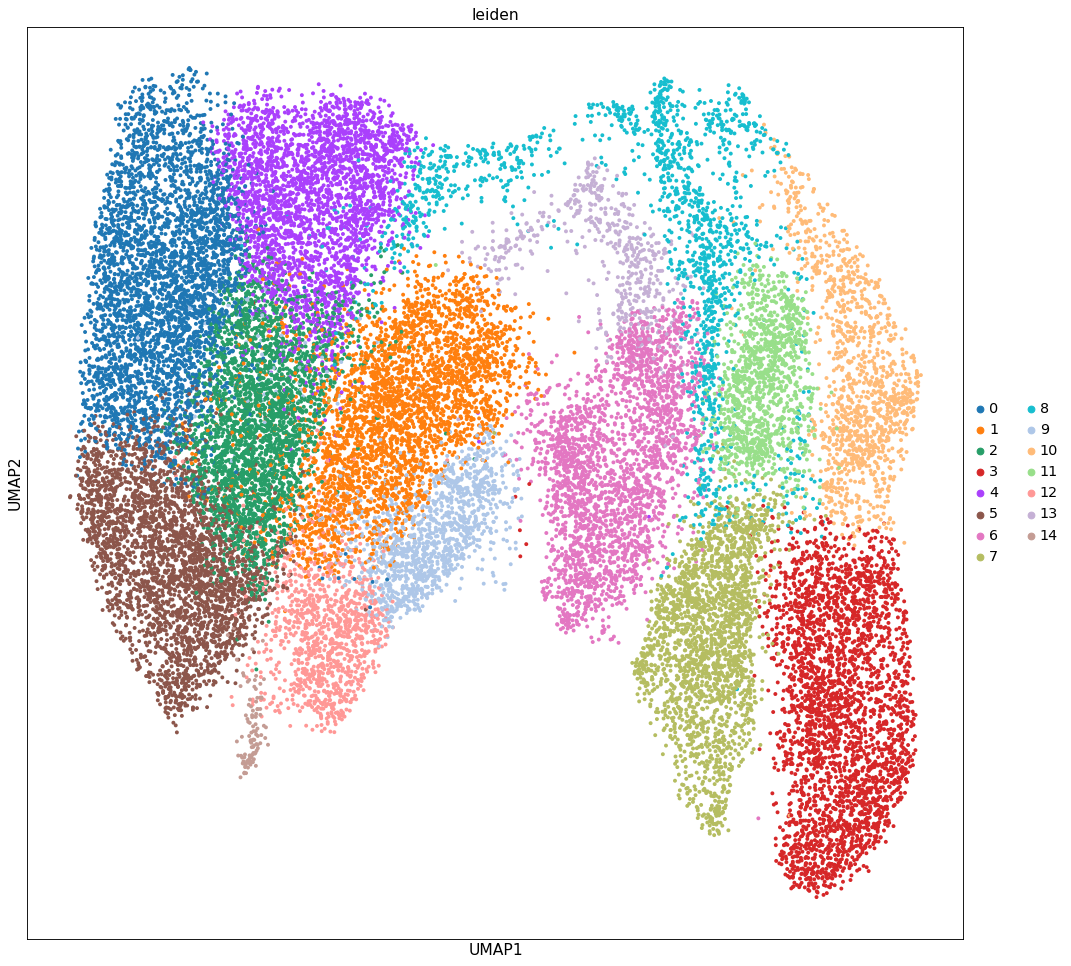

In [35]:
sc.pl.umap(concatendated_arabi_maize_dataset, color= 'leiden', s = 50)

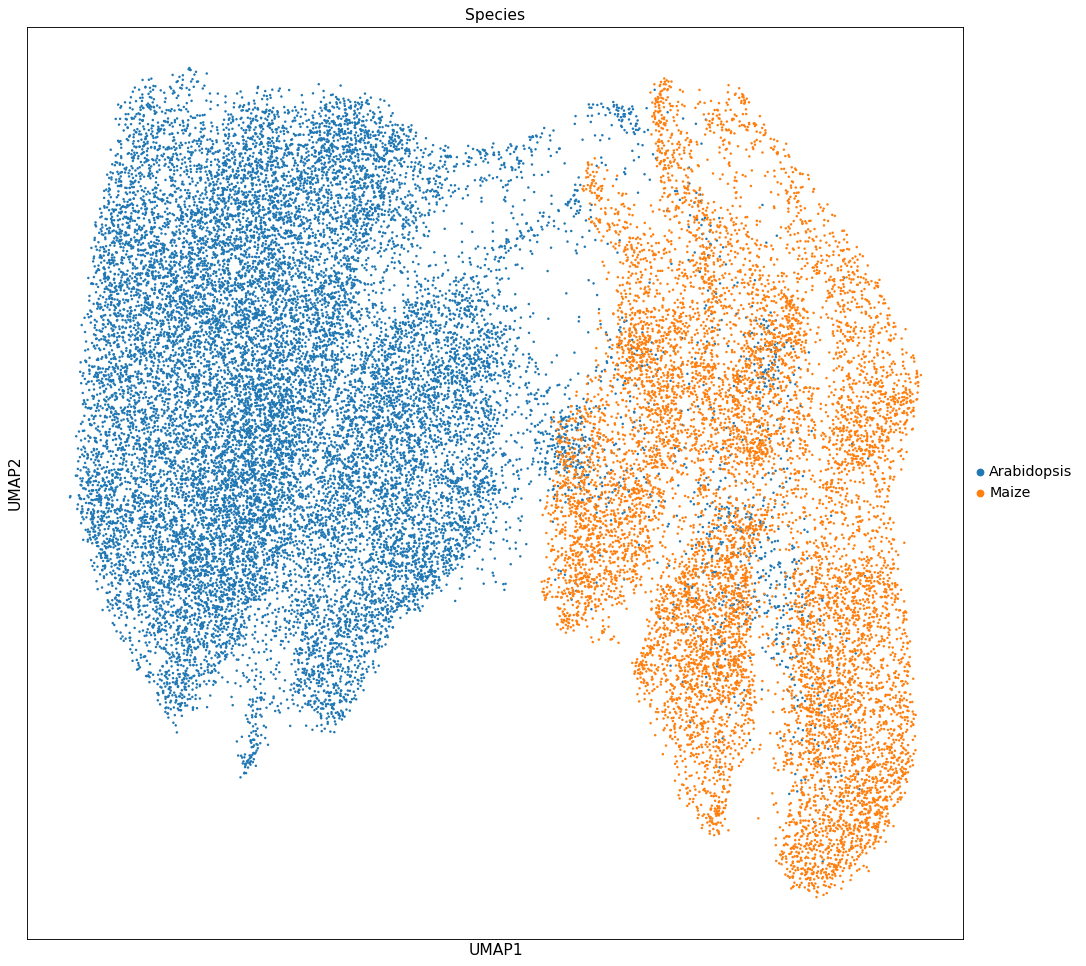

In [36]:
sc.pl.umap(concatendated_arabi_maize_dataset, color='Species', s= 20, palette =['tab:blue','tab:orange'])


In [ ]:
#maize_single_cell.obs['leiden'] = maize_single_cell_trimmed_to_orthologs.obs['leiden']

In [ ]:
maize_single_cell

In [ ]:
#sc.pl.umap(maize_single_cell, color= 'leiden', s = 50)

In [ ]:
sc.tl.ingest(arabi_single_cell_slimmed_to_orthologs,maize_single_cell_trimmed_to_orthologs, obs = 'leiden')
arabi_single_cell_slimmed_to_orthologs.uns['leiden_colors'] = maize_single_cell_trimmed_to_orthologs.uns['leiden_colors']  # fix colors


In [ ]:
sc.pl.umap(arabi_single_cell_slimmed_to_orthologs, color='leiden', wspace=0.5, s = 40)


In [ ]:
concatendated_arabi_maize_dataset.obs.leiden = concatendated_arabi_maize_dataset.obs.leiden.astype('category')
concatendated_arabi_maize_dataset.obs.leiden.cat.reorder_categories(maize_single_cell_trimmed_to_orthologs.obs.leiden.cat.categories, inplace=True)  # fix category ordering
concatendated_arabi_maize_dataset.uns['leiden_colors'] = maize_single_cell_trimmed_to_orthologs.uns['leiden_colors']  # fix category colors




In [ ]:
sc.pl.umap(concatendated_arabi_maize_dataset, color='leiden', s= 20)


In [ ]:
concatendated_arabi_maize_dataset

In [ ]:
pymn.variableGenes(concatendated_arabi_maize_dataset,study_col = 'Species')
pymn.MetaNeighborUS(concatendated_arabi_maize_dataset,study_col = 'Species',ct_col = 'leiden')
pymn.plotMetaNeighborUS(concatendated_arabi_maize_dataset,figsize = (20,20),cmap = 'coolwarm',fontsize = 15)

In [ ]:
list_of_leiden_groups = np.arange(0,15,1)

In [ ]:
list_of_leiden_columns = []
for species in ['Maize','Arabidopsis']:
    for group in list_of_leiden_groups:
        current_group = f'{species} Cluster {group}'
        list_of_leiden_columns.append(current_group)
        

In [ ]:
list_of_leiden_columns

In [ ]:
data_frame_of_centroid_results = pd.DataFrame(index = concatendated_arabi_maize_dataset.var_names, columns = list_of_leiden_columns)
data_frame_of_centroid_results

In [ ]:
for group in list_of_leiden_groups:
    print(group)
    group = str(group)
    both_species_subset = concatendated_arabi_maize_dataset[concatendated_arabi_maize_dataset.obs['leiden'] == group]
    maize_subset = both_species_subset[both_species_subset.obs['Species'] == 'Maize']
    arabi_subset = both_species_subset[both_species_subset.obs['Species'] == 'Arabidopsis']
    current_maize = f'Maize Cluster {group}'
    data_frame_of_centroid_results[current_maize] = maize_subset.X.mean(axis = 0).tolist()[0]
    current_arab = f'Arabidopsis Cluster {group}'
    data_frame_of_centroid_results[current_arab] = arabi_subset.X.mean(axis = 0).tolist()[0]

    

In [ ]:
maize_columns = []
for group in list_of_leiden_groups:
    current_group = f'Maize Cluster {group}'
    maize_columns.append(current_group)

In [ ]:
arabi_columns = []
for group in list_of_leiden_groups:
    current_group = f'Arabidopsis Cluster {group}'
    arabi_columns.append(current_group)

In [ ]:
arabi_columns

In [ ]:
len(maize_subset.X.mean(axis = 1))

In [ ]:
combo_list = list(itertools.product(maize_columns, arabi_columns))


In [ ]:
results_for_heat_map = pd.DataFrame(index = maize_columns, columns = arabi_columns)
results_for_heat_map

In [ ]:
data_frame_of_centroid_results

In [ ]:
for combo in combo_list:
    maize_column = combo[0]
    arabidop_column = combo[1]
    maize_gene_results = data_frame_of_centroid_results[maize_column]
    arabidop_gene_results = data_frame_of_centroid_results[arabidop_column]
    correlation_result = maize_gene_results.corr(arabidop_gene_results, method = 'spearman')
    results_for_heat_map.at[maize_column,arabidop_column] = correlation_result
    


In [ ]:
results_for_heat_map